# Implementation of different versions of the benefit difference fairness function

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import multiprocessing as mp
from src.util import sigmoid
from src.feature_map import IdentityFeatureMap
from src.functions import cost_utility, demographic_parity
from src.plotting import plot_mean_over_lambdas, plot_median_over_lambdas
from src.training import train_multiple
from src.distribution import SplitDistribution

## The parameters used by the the original authors  

In [2]:
bias = True
dim_x = 1
dim_theta = dim_x + 1 if bias else dim_x

lambdas = np.logspace(-1, 2, base=10, endpoint=True, num=100)
lambdas = np.insert(arr=lambdas, obj=0, values=[0.0])

iterations=30

def util_func(**util_params):
    util = cost_utility(cost_factor=0.55, **util_params)
    return util

training_parameters = {    
    'model':{
        'theta': [-3.5, 0.6],
        'benefit_value_function': demographic_parity,
        'utility_value_function': util_func,
        'feature_map': IdentityFeatureMap(dim_theta),
        'keep_collected_data': False,
        'use_sensitve_attributes': False,
        'bias': bias,
        'save_path': "/home/fkretschmar/Documents/master-thesis/res/exp-004/models"
    },
    'optimization': {
        'time_steps':200,
        'epochs': 32,
        'batch_size':512,
        'learning_rate': 0.5,
        'decay_rate': 0.8,
        'decay_step': 30,
        'fairness_rates': lambdas,
        'test_at_every_timestep': False
    },
    'data': {
        'distribution': SplitDistribution(bias=bias),
        'keep_data_across_lambdas': True,
        'fraction_protected':0.5,
        'num_test_samples': 819200,
        'num_decisions': 32 * 512
    }
}


## Correct Benefit Difference

91488954
Median: 0.01221941991339415
Last quartile: 0.21838341802725497
--------------------------------------------------
------------------- Lambda 10.722672220103231 -------------------
--------------------------------------------------
------------------- Utility ----------------------
Mean: 0.011731762695312502
Standard deviation: 0.017310004663714015
First quartile: 0.0006286773681640624
Median: 0.0034339904785156243
Last quartile: 0.016129837036132806
------------------- Benefit Delta ----------------
Mean: 0.0834476982291206
Standard deviation: 0.12652942677584647
First quartile: 0.0038432007931824943
Median: 0.013865424364536187
Last quartile: 0.07069071107913377
--------------------------------------------------
------------------- Lambda 11.497569953977356 -------------------
--------------------------------------------------
------------------- Utility ----------------------
Mean: 0.013303631591796873
Standard deviation: 0.026230505605891637
First quartile: 2.92053222656249

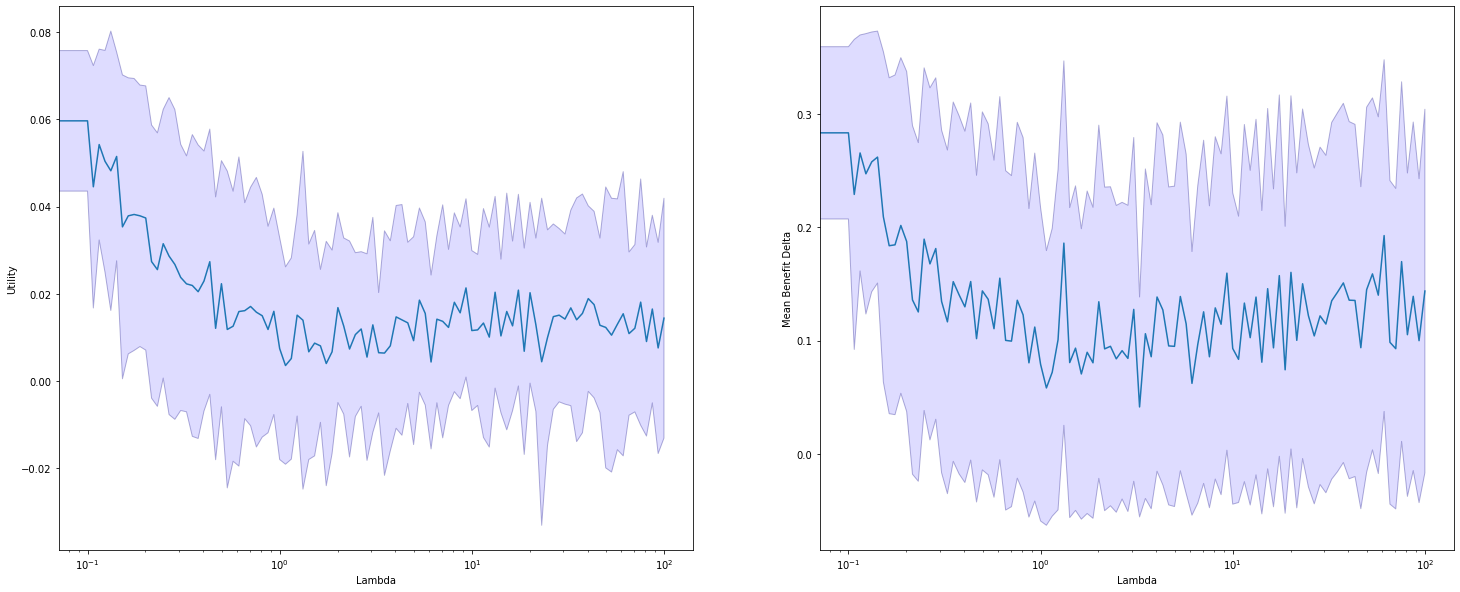

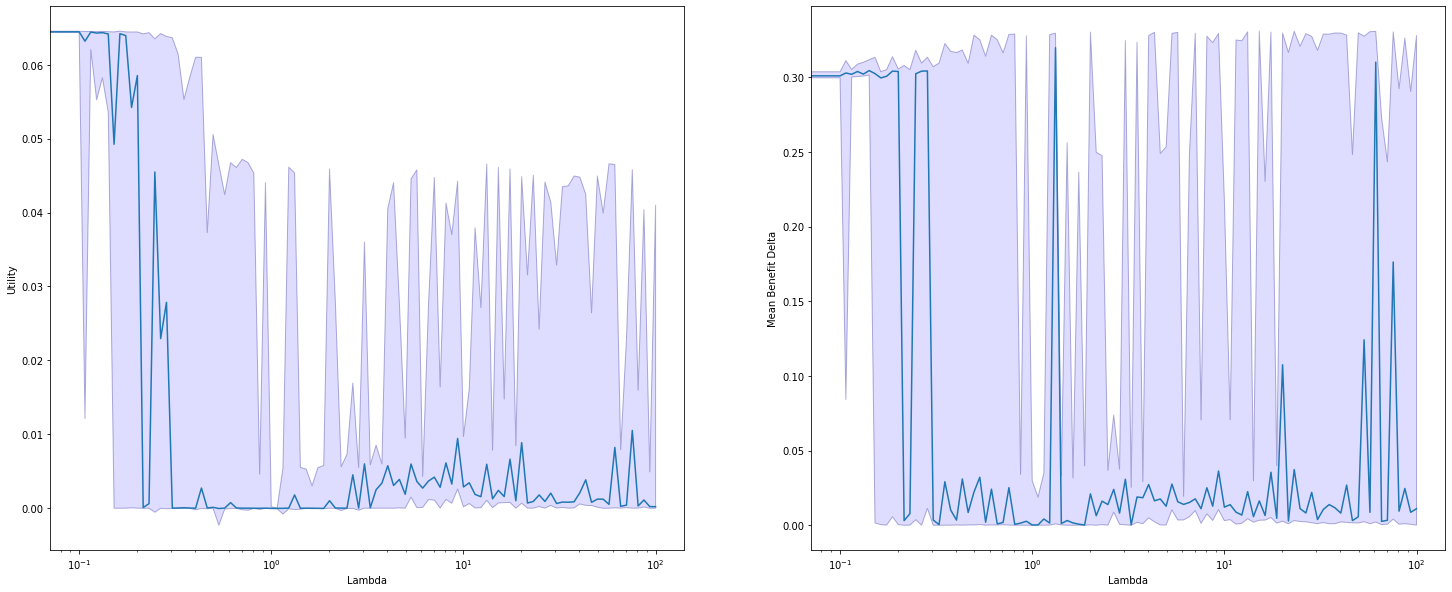

In [3]:
def fairness_function(**fairness_kwargs):
    policy = fairness_kwargs["policy"]
    x = fairness_kwargs["x"]
    s = fairness_kwargs["s"]
    y = fairness_kwargs["y"]
    decisions = fairness_kwargs["decisions"]
    ips_weights = fairness_kwargs["ips_weights"]

    benefit = policy.benefit_function(decisions=decisions, y=y)

    if ips_weights is not None:
        benefit *= ips_weights

    log_gradient = policy._log_gradient(x, s)
    benefit_grad = benefit * log_gradient
        
    # benefit-difference * grad-benefit-difference
    return policy._mean_difference(benefit, s) * policy._mean_difference(benefit_grad, s)

training_parameters["model"]['fairness_function'] = fairness_function

statistics = train_multiple(training_parameters, iterations=iterations, verbose=True, asynchronous=True)

plot_mean_over_lambdas(statistics, "results_mean.png")
plot_median_over_lambdas(statistics, "results_median.png")